# Ranking Object Similarity Demo

In [1]:
from scipy import ndimage
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

### Define Functions

In [2]:
'''RGB image to grayscale image'''
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def gradient_intensity(img):
    """ Step 2: Find gradients
    Args:
        img: Numpy ndarray of image to be processed (denoised image)
    Returns:
        G: gradient-intensed image
        D: gradient directions
        Ix: x-gradient image
        Iy: y-gradient image
    """
    # Kernel for Gradient in x-direction
    Kx = np.array(
        [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.int32
    )
    # Kernel for Gradient in y-direction
    Ky = np.array(
        [[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.int32
    )
    # Apply kernels to the image
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)

    # return the hypothenuse of (Ix, Iy)
    G = np.hypot(Ix, Iy)
    D = np.arctan2(Iy, Ix)
    return (G, D, Ix, Iy)

def compute_binarized_gradient_orientation(I):
    gray = rgb2gray(I)  
    I_gau=cv2.GaussianBlur(gray,(5,5),0)            #(5,5) is the size of the Gaussian Filter. You can change it to other sizes     
    G, D, Ix, Iy = gradient_intensity(I_gau)
    normalize_G = G/G.max()
    for i in range(normalize_G.shape[0]):
        for j in range(normalize_G.shape[1]):
            if normalize_G[i,j] > 0.2:
                normalize_G[i,j] = 1
            else:
                normalize_G[i,j] = 0
                
    binarized_D = normalize_G*D
    binarized_D_vector = binarized_D.reshape((40000,1))
    hist,bins = np.histogram(binarized_D_vector,bins=32)
    
    return hist, binarized_D

### Load Input Image and Display

In [23]:
plt.rcParams["figure.figsize"] = [5, 5]

'''load and show the original image'''
I_reference = np.array(Image.open('test_images/reference_images/face2.jpg').convert('RGB').resize((200,200)))
hist_reference, binarized_D_reference = compute_binarized_gradient_orientation(I_reference)
plt.figure()
plt.imshow(I_reference)
plt.title('reference image')
plt.axis('off')

(-0.5, 199.5, 199.5, -0.5)

### Visualize Gradient Map and Orietation

In [24]:
plt.rcParams["figure.figsize"] = [10, 10]

gray = rgb2gray(I_reference)  
I_gau=cv2.GaussianBlur(gray,(5,5),0)            #(5,5) is the size of the Gaussian Filter. You can change it to other sizes     
G, D, Ix, Iy = gradient_intensity(I_gau)

plt.subplot(2,2,1)
plt.imshow(Ix)
plt.title('Gradient Map in Horizontal Direction')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(Iy)
plt.title('Gradient Map in Vertical Direction')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(G)
plt.title('Gradient Magnitude Map')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(D)
plt.title('Gradient Orientation Map')
plt.axis('off')

(-0.5, 199.5, 199.5, -0.5)

### Ranking Object Similarity Using Binarized Gradient Orientation

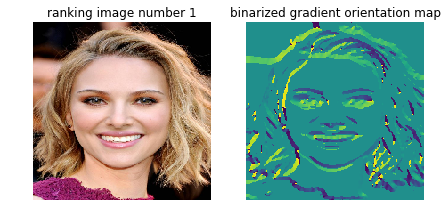

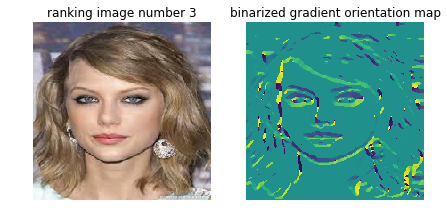

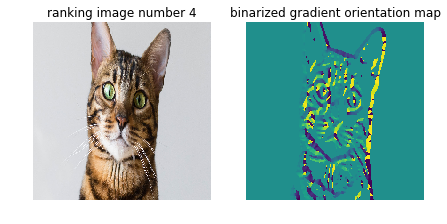

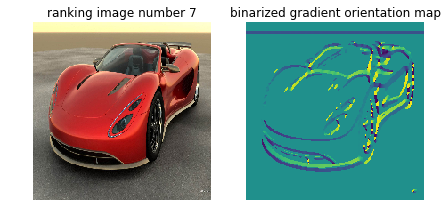

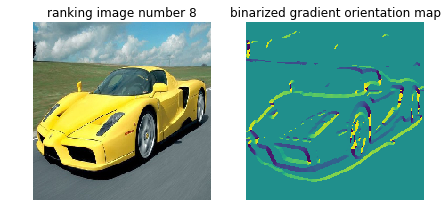

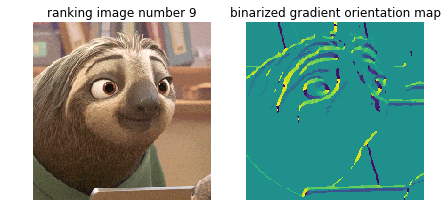

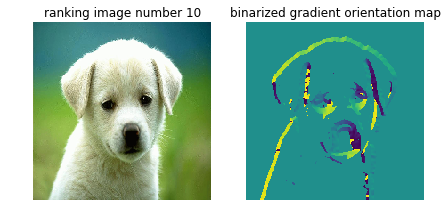

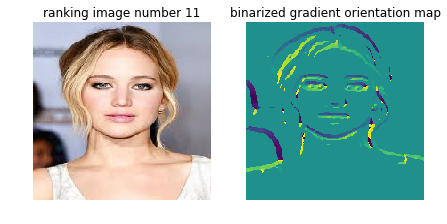

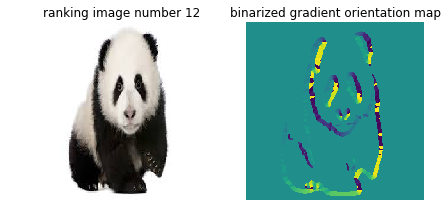

In [25]:
plt.rcParams["figure.figsize"] = [5, 5]

plt.imshow(I_reference)
plt.title('reference image')
plt.axis('off')

import glob
from scipy.stats import wasserstein_distance
similarity_score_arr = np.array([])
img_index = 0
image_list = []
binarized_D_ranking_list = []
for img_file in glob.glob('test_images/ranking_images/*'):
    I_ranking = np.array(Image.open(img_file).convert('RGB').resize((200,200)))
    image_list.append(I_ranking)
    hist_ranking, binarized_D_ranking = compute_binarized_gradient_orientation(I_ranking)
    binarized_D_ranking_list.append(binarized_D_ranking)
    #    similarity_score, bins = chisquare(hist_reference,hist_ranking)
    similarity_score = wasserstein_distance(hist_reference,hist_ranking)
    similarity_score_arr = np.append(similarity_score_arr, similarity_score)
    img_index += 1

rank_index = np.argsort(similarity_score_arr)

plt.rcParams["figure.figsize"] = [7, 7]

for i in range(similarity_score_arr.shape[0]):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image_list[rank_index[i]])
    plt.title('ranking image number '+str(i+1))
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(binarized_D_ranking_list[rank_index[i]])
    plt.title('binarized gradient orientation map')
    plt.axis('off')    

### Ranking Object Similarity Using CNN Features

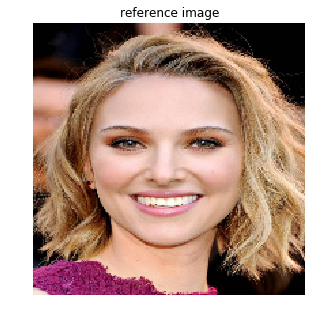

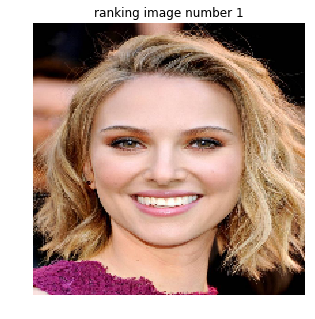

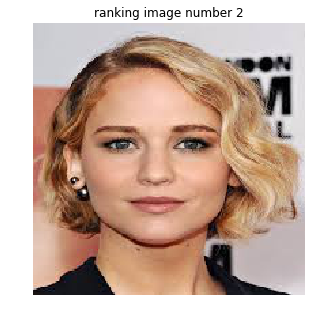

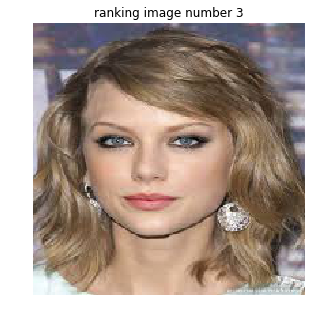

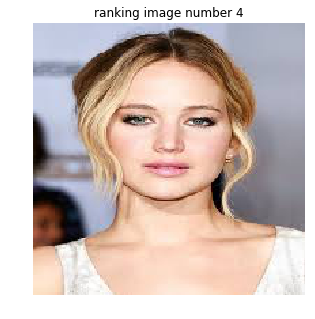

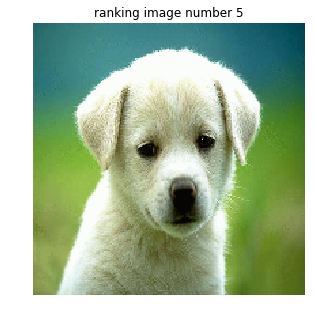

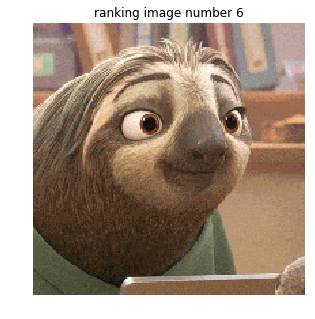

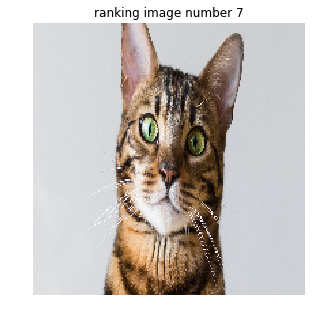

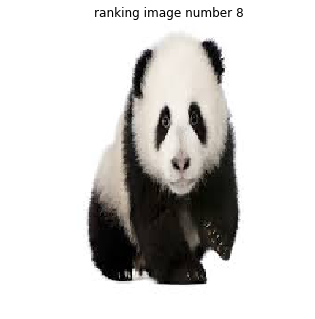

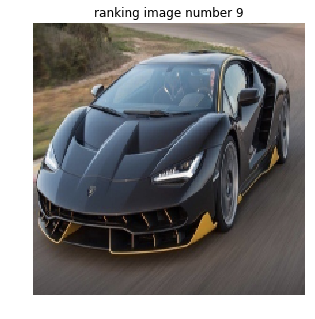

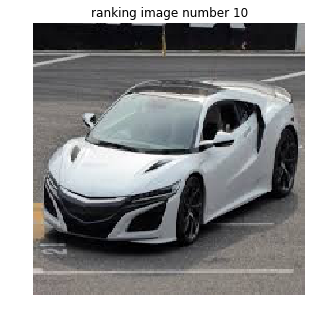

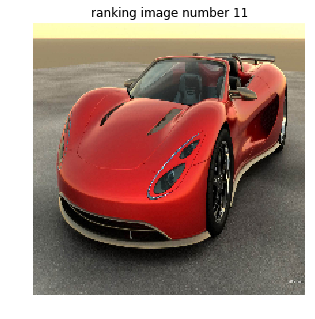

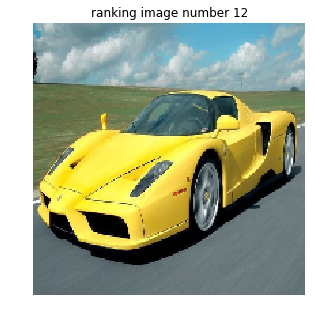

In [26]:
import torch
import torch.nn as nn
import torchvision.models as models
from scipy.spatial.distance import cosine
# extract CNN feature for each frame in video
class pretrainedAlexNet(nn.Module):
    def __init__(self):
        super(pretrainedAlexNet, self).__init__()
        self.my_features = models.alexnet(pretrained = True).features

    def forward(self, input):
        feature_map = self.my_features(input)
        return feature_map

net = pretrainedAlexNet()

plt.rcParams["figure.figsize"] = [5, 5]

# TODO: You can change the reference image here
I_reference = np.array(Image.open('test_images/reference_images/face2.jpg').convert('RGB').resize((200,200)))

I_reference_tensor = torch.from_numpy(I_reference).unsqueeze(0).transpose(1,3).transpose(2,3).float()
plt.figure()
plt.imshow(I_reference)
plt.title('reference image')
plt.axis('off')

cnn_feature_reference = net(I_reference_tensor)
cnn_feature_reference = cnn_feature_reference.view(-1,1)
cnn_feature_reference_np = cnn_feature_reference.data.numpy()

img_index = 0
image_list = []
cosine_similarity_score_arr = np.array([])
for img_file in glob.glob('test_images/ranking_images/*'):
    I_ranking = np.array(Image.open(img_file).convert('RGB').resize((200,200)))
    image_list.append(I_ranking)
    I_ranking_tensor = torch.from_numpy(I_ranking).unsqueeze(0).transpose(1,3).transpose(2,3).float()
    cnn_feature_ranking = net(I_ranking_tensor)
    cnn_feature_ranking = cnn_feature_ranking.view(-1,1)
    cnn_feature_ranking_np = cnn_feature_ranking.data.numpy()
    cosine_similarity_score = cosine(cnn_feature_reference_np, cnn_feature_ranking_np)
    cosine_similarity_score_arr = np.append(cosine_similarity_score_arr, cosine_similarity_score)

rank_index = np.argsort(cosine_similarity_score_arr)

for i in range(similarity_score_arr.shape[0]):
    plt.figure()
    plt.imshow(image_list[rank_index[i]])
    plt.title('ranking image number '+str(i+1))
    plt.axis('off')